In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

In [21]:
# set pandas to display all columns
pd.set_option('display.max_columns', None)

#### 1. Data Preprocessing

In [22]:
# define the path to the file
file_path = 'data/tool_sensor_data.csv'

# read the csv file
df = pd.read_csv(file_path)

# rename column
column_dict = {
    'TimeStamp': 'timestamp',
    'ToolName': 'tool_name',
    'TOOL_ID': 'tool_id',
    'Run': 'run',
    'RunStartTime': 'run_start_time',
    'DATA_QUALITY': 'data_quality',
    'EQPType': 'eqp_type',
    'HasComments': 'has_comments',
    'LOT_ID': 'lot_id',
    'LogicalRecipeID': 'logical_recipe_id',
    'LotPurposeType': 'lot_purpose_type',
    'LotType': 'lot_type',
    'MachineRecipeID': 'machine_recipe_id',
    'PhysicalRecipeID': 'physical_recipe_id',
    'PortID': 'port_id',
    'ProcessOpNum': 'process_op_num',
    'ProductGrpID': 'product_grp_id',
    'ProductID': 'product_id',
    'RECIPE_ID': 'recipe_id',
    'ReticleID': 'reticle_id',
    'RouteID': 'route_id',
    'Technology': 'technology',
    'WAFER_ID': 'wafer_id',
    'EventType': 'event_type',
    'EventName': 'event_name',
    'EventId': 'event_id',
    'EventSource': 'event_source',
    'EventDescription': 'event_description',
    'AlarmCode': 'alarm_code',
    'AlarmStatus': 'alarm_status',
    'CalcStepSeq': 'calc_step_seq',
    'CalcLoopSeq': 'calc_loop_seq',
    'RunTag': 'run_tag',
    'Unnamed: 85': 'unnamed_85',
    'Unnamed: 86': 'unnamed_86',
    'Unnamed: 87': 'unnamed_87',
    'Unnamed: 88': 'unnamed_88',
    'Unnamed: 89': 'unnamed_89'
}
columns_not_in_dict = [col for col in df.columns if col not in column_dict.keys()]
columns_not_in_dict = {col: f'tool_sensor_{i + 1}' for i, col in enumerate(columns_not_in_dict) if col not in column_dict.keys()}

merged_dict = {**column_dict, **columns_not_in_dict}

df.rename(columns = merged_dict, inplace = True)

# display top 10 rows
df.head(10)

,timestamp,tool_name,tool_id,run,run_start_time,data_quality,eqp_type,has_comments,lot_id,logical_recipe_id,lot_purpose_type,lot_type,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,reticle_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_2,tool_sensor_3,tool_sensor_4,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_22,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_27,tool_sensor_28,tool_sensor_29,tool_sensor_30,tool_sensor_31,tool_sensor_32,tool_sensor_33,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_41,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,tool_sensor_46,event_type,event_name,event_id,event_source,event_description,alarm_code,alarm_status,tool_sensor_47,tool_sensor_48,tool_sensor_49,tool_sensor_50,tool_sensor_51,tool_sensor_52,calc_step_seq,calc_loop_seq,run_tag,unnamed_85,unnamed_86,unnamed_87,unnamed_88,unnamed_89
0,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,StartOfRun,WaferStart,WaferStart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,56.0,0.98,1.0,1.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.0,0.00,98.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,0.74,2.0,500.0,81.0,-25.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
2,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,148.0,0.98,1.0,1.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.0,0.00,200.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,0.74,7.0,300.0,81.0,1890.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
3,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,12.0,0.98,1.0,1.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,0.0,35.0,4.04,206.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,0.74,8.0,300.0,81.0,1890.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,19.0,0.98,1.0,1.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,0.0,40.0,7.05,199.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,0.74,9.0,6200.0,81.0,1890.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
5,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,100.0,0.98,1.0,1.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.15,201.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,0.74,11.0,1400.0,81.0,1890.0,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
6,21/3/2023 19:15,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,NaN,A,A,1,140.0,0.98,1.0,1.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,6.0,11.0,5.0,13

In [23]:
# display the shape of the dataframe
print(f"there are total {df.shape[0]} rows, and {df.shape[1]} columns")

there are total 14844 rows, and 90 columns


In [24]:
# visualize dataset description
dataset_description = df.describe()
dataset_description

,run,data_quality,has_comments,reticle_id,wafer_id,tool_sensor_1,tool_sensor_2,tool_sensor_3,tool_sensor_4,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_22,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_27,tool_sensor_28,tool_sensor_29,tool_sensor_30,tool_sensor_31,tool_sensor_32,tool_sensor_33,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_41,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,tool_sensor_46,event_source,event_description,alarm_code,alarm_status,tool_sensor_47,tool_sensor_48,tool_sensor_49,tool_sensor_50,tool_sensor_51,tool_sensor_52,calc_step_seq,calc_loop_seq,run_tag,unnamed_85,unnamed_86,unnamed_87,unnamed_88,unnamed_89
count,14844.000000,14844.000000,14844.0,0.0,14844.000000,14388.000000,1.438800e+04,14388.0,14388.0,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.00000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,14388.0,14388.000000,14388.000000,14388.000000,14388.000000,1.438800e+04,14388.0,14388.0,14388.0,14388.0,14388.0,14388.0,14388.000000,14388.00000,14388.000000,14388.000000,14388.000000,14388.000000,14388.000000,1.438800e+04,14616.000000,14388.000000,14388.000000,14388.000000,14388.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14616.000000,14616.000000,0.0,0.0,0.0,0.0,0.0,0.0
mean,62437.529103,70.762264,0.0,NaN,12.707154,115.818807,9.800000e-01,1.0,1.0,5.817178,357.031902,119.584306,128.832013,144.414790,131.818668,-64.933208,3.031485,0.721768,6.99517,6.295957,0.447252,9.487216,793.013970,105.060676,15.189718,119.680289,0.0,45.704615,7.798031,204.472130,2.319363,7.380000e-01,0.0,0.0,0.0,0.0,0.0,0.0,4988.246733,2003.24854,4.106686,6.471574,3.615582,1175.201001,2741.521407,7.400000e-01,13.456897,25574.117320,96.026967,1838.558173,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.289135,6.289135,NaN,NaN,NaN,NaN,NaN,NaN
std,90.607731,15.702130,0.0,NaN,7.111389,54.891018,3.330785e-16,0.0,0.0,5.575780,29.851953,0.800654,2.971084,8.829543,6.194255,33.729107,0.427290,4.350116,0.12156,0.770134,0.769185,0.076229,363.044767,23.890697,3.507948,46.542424,0.0,30.753165,4.941302,24.192323,0.123312,2.220523e-16,0.0,0.0,0.0,0.0,0.0,0.0,90.586950,1226.93936,10.558384,10.973962,7.816805,326.913416,830.014541,1.110262e-16,5.247933,23817.306287,10.470464,304.102331,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.097085,3.097085,NaN,NaN,NaN,NaN,NaN,NaN
min,62301.000000,42.330000,0.0,NaN,1.000000,10.000000,9.800000e-01,1.0,1.0,0.410000,293.000000,118.000000,120.000000,117.000000,119.000000,-512.000000,1.000000,0.000000,3.26000,4.320000,0.000000,7.030000,10.000000,0.000000,0.060000,0.000000,0.0,0.000000,0.000000,82.000000,2.130000,7.380000e-01,0.0,0.0,0.0,0.0,0.0,0.0,4852.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,7.400000e-01,-2.000000,0.000000,81.000000,-25.000000,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,62359.000000,58.560000,0.0,NaN,6.750000,91.000000,9.800000e-01,1.0,1.0,4.420000,330.000000,119.000000,126.000000,140.000000,126.000000,-83.000000,3.000000,0.000000,7.00000,6.200000,0.310000,9.490000,952.000000,111.000000,16.030000,106.000000,0.0,18.000000,3.812500,203.000000,2.170000,7.380000e-01,0.0,0.0,0.0,0.0,0.0,0.0,4910.000000,38.75000,0.000000,5.000000,2.000000,1302.000000,3103.000000,7.400000e-01,11.000000,3600.000000,87.000000,1890.000000,75.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,62408.000000,63.890000,0.0,NaN,13.000000,144.000000,9.800000e-01,1.0,1.0,4.920000,366.000000,120.000000,129.000000,146.000000,134.000000,-78.000000,3.000000,0.400000,7.00000,6.290000,0.450000,9.49

In [25]:
# set pandas to display all rows
pd.set_option('display.max_rows', None)

# find missing (na) values
na_values = df.isna().sum()

print(na_values)

timestamp                 0
tool_name                 0
tool_id                   0
run                       0
run_start_time            0
data_quality              0
eqp_type                  0
has_comments              0
lot_id                    0
logical_recipe_id         0
lot_purpose_type          0
lot_type                  0
machine_recipe_id         0
physical_recipe_id        0
port_id                   0
process_op_num            0
product_grp_id            0
product_id                0
recipe_id                 0
reticle_id            14844
route_id                  0
technology                0
wafer_id                  0
tool_sensor_1           456
tool_sensor_2           456
tool_sensor_3           456
tool_sensor_4           456
tool_sensor_5           456
tool_sensor_6           456
tool_sensor_7           456
tool_sensor_8           456
tool_sensor_9           456
tool_sensor_10          456
tool_sensor_11          456
tool_sensor_12          456
tool_sensor_13      

In [26]:
# columns with exactly 14844 missing values
columns_with_14844_na = na_values[na_values == 14844].index.tolist()

# print the list of columns
print(columns_with_14844_na)

['reticle_id', 'event_source', 'event_description', 'alarm_code', 'alarm_status', 'tool_sensor_47', 'tool_sensor_48', 'tool_sensor_49', 'tool_sensor_50', 'tool_sensor_51', 'tool_sensor_52', 'run_tag', 'unnamed_85', 'unnamed_86', 'unnamed_87', 'unnamed_88', 'unnamed_89']


In [27]:
# check for columns with 14388 NA values and their unique values
columns_with_14388_na = na_values[na_values == 14388].index.tolist()

for column in columns_with_14388_na:
    # get unique values of the column
    unique_values = df[column].unique()
    print(f"unique values in '{column}':", unique_values)

unique values in 'event_type': ['StartOfRun' nan 'EndOfRun']
unique values in 'event_name': ['WaferStart' nan 'WaferEnd']
unique values in 'event_id': ['WaferStart' nan 'WaferEnd']


In [28]:
# drop columns with 14844 N/A and 14388 N/A
columns_to_drop = columns_with_14844_na + columns_with_14388_na
df.drop(columns = columns_to_drop, inplace = True)

df.head(10)

,timestamp,tool_name,tool_id,run,run_start_time,data_quality,eqp_type,has_comments,lot_id,logical_recipe_id,lot_purpose_type,lot_type,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_2,tool_sensor_3,tool_sensor_4,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_22,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_27,tool_sensor_28,tool_sensor_29,tool_sensor_30,tool_sensor_31,tool_sensor_32,tool_sensor_33,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_41,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,tool_sensor_46,calc_step_seq,calc_loop_seq
0,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,56.0,0.98,1.0,1.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.0,0.00,98.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,0.74,2.0,500.0,81.0,-25.0,75.0,1.0,1.0
2,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,148.0,0.98,1.0,1.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.0,0.00,200.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,0.74,7.0,300.0,81.0,1890.0,75.0,2.0,2.0
3,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,12.0,0.98,1.0,1.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,0.0,35.0,4.04,206.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,0.74,8.0,300.0,81.0,1890.0,75.0,3.0,3.0
4,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,19.0,0.98,1.0,1.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,0.0,40.0,7.05,199.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,0.74,9.0,6200.0,81.0,1890.0,75.0,4.0,4.0
5,21/3/2023 19:14,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,100.0,0.98,1.0,1.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.15,201.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,0.74,11.0,1400.0,81.0,1890.0,75.0,5.0,5.0
6,21/3/2023 19:15,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,140.0,0.98,1.0,1.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,6.0,11.0,5.0,1304.0,3110.0,0.74,11.0,9800.0,81.0,1890.0,75.0,5.0,5.0
7,21/3/2023 19:15,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,145.0,0.98,1.0,1.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,0.74,11.0,11300.0,81.0,1890.0,75.0,5.0,5.0
8,21/3/2023 19:15,A,A,62301,12:14:19 AM,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,145.0,0.98,1.0,1.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,0.74,11.0,11300.0,81.0,1890.0,75.0,5.0,5.0
9,21/

In [29]:
# removing rows that still have missing values after drop certain columns
# criteria > 227
rows_to_drop = na_values[na_values > 227].index.tolist()

rows_to_drop_set = set(rows_to_drop)
columns_to_drop_set = set(columns_to_drop)

filtered_rows_to_drop = rows_to_drop_set - columns_to_drop_set
filtered_rows_to_drop = list(filtered_rows_to_drop)

df.dropna(subset = filtered_rows_to_drop, inplace = True)

In [30]:
# stored in a format that is machine-readable, so can do time-based filtering, grouping,
# and plotting later in your analysis
df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%d/%m/%Y %H:%M')
df['run_start_time'] = pd.to_datetime(df['run_start_time'], format = '%I:%M:%S %p').dt.time

df.head(10)

,timestamp,tool_name,tool_id,run,run_start_time,data_quality,eqp_type,has_comments,lot_id,logical_recipe_id,lot_purpose_type,lot_type,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_2,tool_sensor_3,tool_sensor_4,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_22,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_27,tool_sensor_28,tool_sensor_29,tool_sensor_30,tool_sensor_31,tool_sensor_32,tool_sensor_33,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_41,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,tool_sensor_46,calc_step_seq,calc_loop_seq
1,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,56.0,0.98,1.0,1.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.0,0.00,98.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,0.74,2.0,500.0,81.0,-25.0,75.0,1.0,1.0
2,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,148.0,0.98,1.0,1.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.0,0.00,200.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,0.74,7.0,300.0,81.0,1890.0,75.0,2.0,2.0
3,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,12.0,0.98,1.0,1.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,0.0,35.0,4.04,206.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,0.74,8.0,300.0,81.0,1890.0,75.0,3.0,3.0
4,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,19.0,0.98,1.0,1.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,0.0,40.0,7.05,199.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,0.74,9.0,6200.0,81.0,1890.0,75.0,4.0,4.0
5,2023-03-21 19:14:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,100.0,0.98,1.0,1.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.15,201.0,2.47,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,0.74,11.0,1400.0,81.0,1890.0,75.0,5.0,5.0
6,2023-03-21 19:15:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,140.0,0.98,1.0,1.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,6.0,11.0,5.0,1304.0,3110.0,0.74,11.0,9800.0,81.0,1890.0,75.0,5.0,5.0
7,2023-03-21 19:15:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,145.0,0.98,1.0,1.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,0.74,11.0,11300.0,81.0,1890.0,75.0,5.0,5.0
8,2023-03-21 19:15:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,145.0,0.98,1.0,1.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,0.74,11.0,11300.0,81.0,1890.0,75.0,5.0,5.0
9,2023-03-21 19:15:00,A,A,62301,00:14:19,63.49,A,0,A,A,Process Lot,Production,A,A,A,A,A,A,A,A,A,1,11.0,0.98,1.0,1.0,4.94,347.0,119.0,127.0,146.0,125.0,-73.0,3.0,0.0,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,0.0,49.0,9.14,204.0,2.51,0.738,0.0,0.0,0.0,0.0,0.0,0.0,4852.0,2802.0,4.0,11.0

In [31]:
# removing columns with only one unique value
for column in df.columns:
    print(f"total unique values in '{column}':", len(df[column].unique()))

columns_to_drop = [column for column in df.columns if df[column].nunique() == 1]

df.drop(columns = columns_to_drop, inplace = True)

total unique values in 'timestamp': 894
total unique values in 'tool_name': 1
total unique values in 'tool_id': 1
total unique values in 'run': 228
total unique values in 'run_start_time': 222
total unique values in 'data_quality': 110
total unique values in 'eqp_type': 1
total unique values in 'has_comments': 1
total unique values in 'lot_id': 23
total unique values in 'logical_recipe_id': 1
total unique values in 'lot_purpose_type': 1
total unique values in 'lot_type': 1
total unique values in 'machine_recipe_id': 2
total unique values in 'physical_recipe_id': 2
total unique values in 'port_id': 2
total unique values in 'process_op_num': 6
total unique values in 'product_grp_id': 14
total unique values in 'product_id': 16
total unique values in 'recipe_id': 2
total unique values in 'route_id': 12
total unique values in 'technology': 5
total unique values in 'wafer_id': 25
total unique values in 'tool_sensor_1': 156
total unique values in 'tool_sensor_2': 1
total unique values in 'too

In [32]:
# check after dropping columns and rows
df.isna().sum()

timestamp             0
run                   0
run_start_time        0
data_quality          0
lot_id                0
machine_recipe_id     0
physical_recipe_id    0
port_id               0
process_op_num        0
product_grp_id        0
product_id            0
recipe_id             0
route_id              0
technology            0
wafer_id              0
tool_sensor_1         0
tool_sensor_5         0
tool_sensor_6         0
tool_sensor_7         0
tool_sensor_8         0
tool_sensor_9         0
tool_sensor_10        0
tool_sensor_11        0
tool_sensor_12        0
tool_sensor_13        0
tool_sensor_14        0
tool_sensor_15        0
tool_sensor_16        0
tool_sensor_17        0
tool_sensor_18        0
tool_sensor_19        0
tool_sensor_20        0
tool_sensor_21        0
tool_sensor_23        0
tool_sensor_24        0
tool_sensor_25        0
tool_sensor_26        0
tool_sensor_34        0
tool_sensor_35        0
tool_sensor_36        0
tool_sensor_37        0
tool_sensor_38  

#### 2. Exploratory Data Analysis

2.1. Time Series Analytics (Tool Sensor)

In [186]:
df.head(10)

,timestamp,run,run_start_time,data_quality,lot_id,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,calc_step_seq,calc_loop_seq
1,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,56.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.00,98.0,2.47,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,500.0,81.0,-25.0,1.0,1.0
2,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,148.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.00,200.0,2.47,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,7.0,300.0,81.0,1890.0,2.0,2.0
3,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,12.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,35.0,4.04,206.0,2.47,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,8.0,300.0,81.0,1890.0,3.0,3.0
4,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,19.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,40.0,7.05,199.0,2.47,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,9.0,6200.0,81.0,1890.0,4.0,4.0
5,2023-03-21 19:14:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,100.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,49.0,9.15,201.0,2.47,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,11.0,1400.0,81.0,1890.0,5.0,5.0
6,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,140.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,6.0,11.0,5.0,1304.0,3110.0,11.0,9800.0,81.0,1890.0,5.0,5.0
7,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0,5.0
8,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0,5.0
9,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,11.0,4.94,347.0,119.0,127.0,146.0,125.0,-73.0,3.0,0.0,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2802.0,4.0,11.0,5.0,1306.0,3108.0,11.0,14500.0,81.0,1890.0,5.0,5.0
10,2023-03-21 19:15:00,62301,00:14:19,63.49,A,A,A,A,A,A,A,A,A,A,1,11.0,4.94,353.0,119.0,127.0,146.0,125.0,-74.0,3.0,0.2,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2803.0,4.0,12.0,5.0,1304.0,3108.0,11.0,16900.0,81.0,1890.0,5.0,5.0


In [187]:
len(df["timestamp"].unique())

894

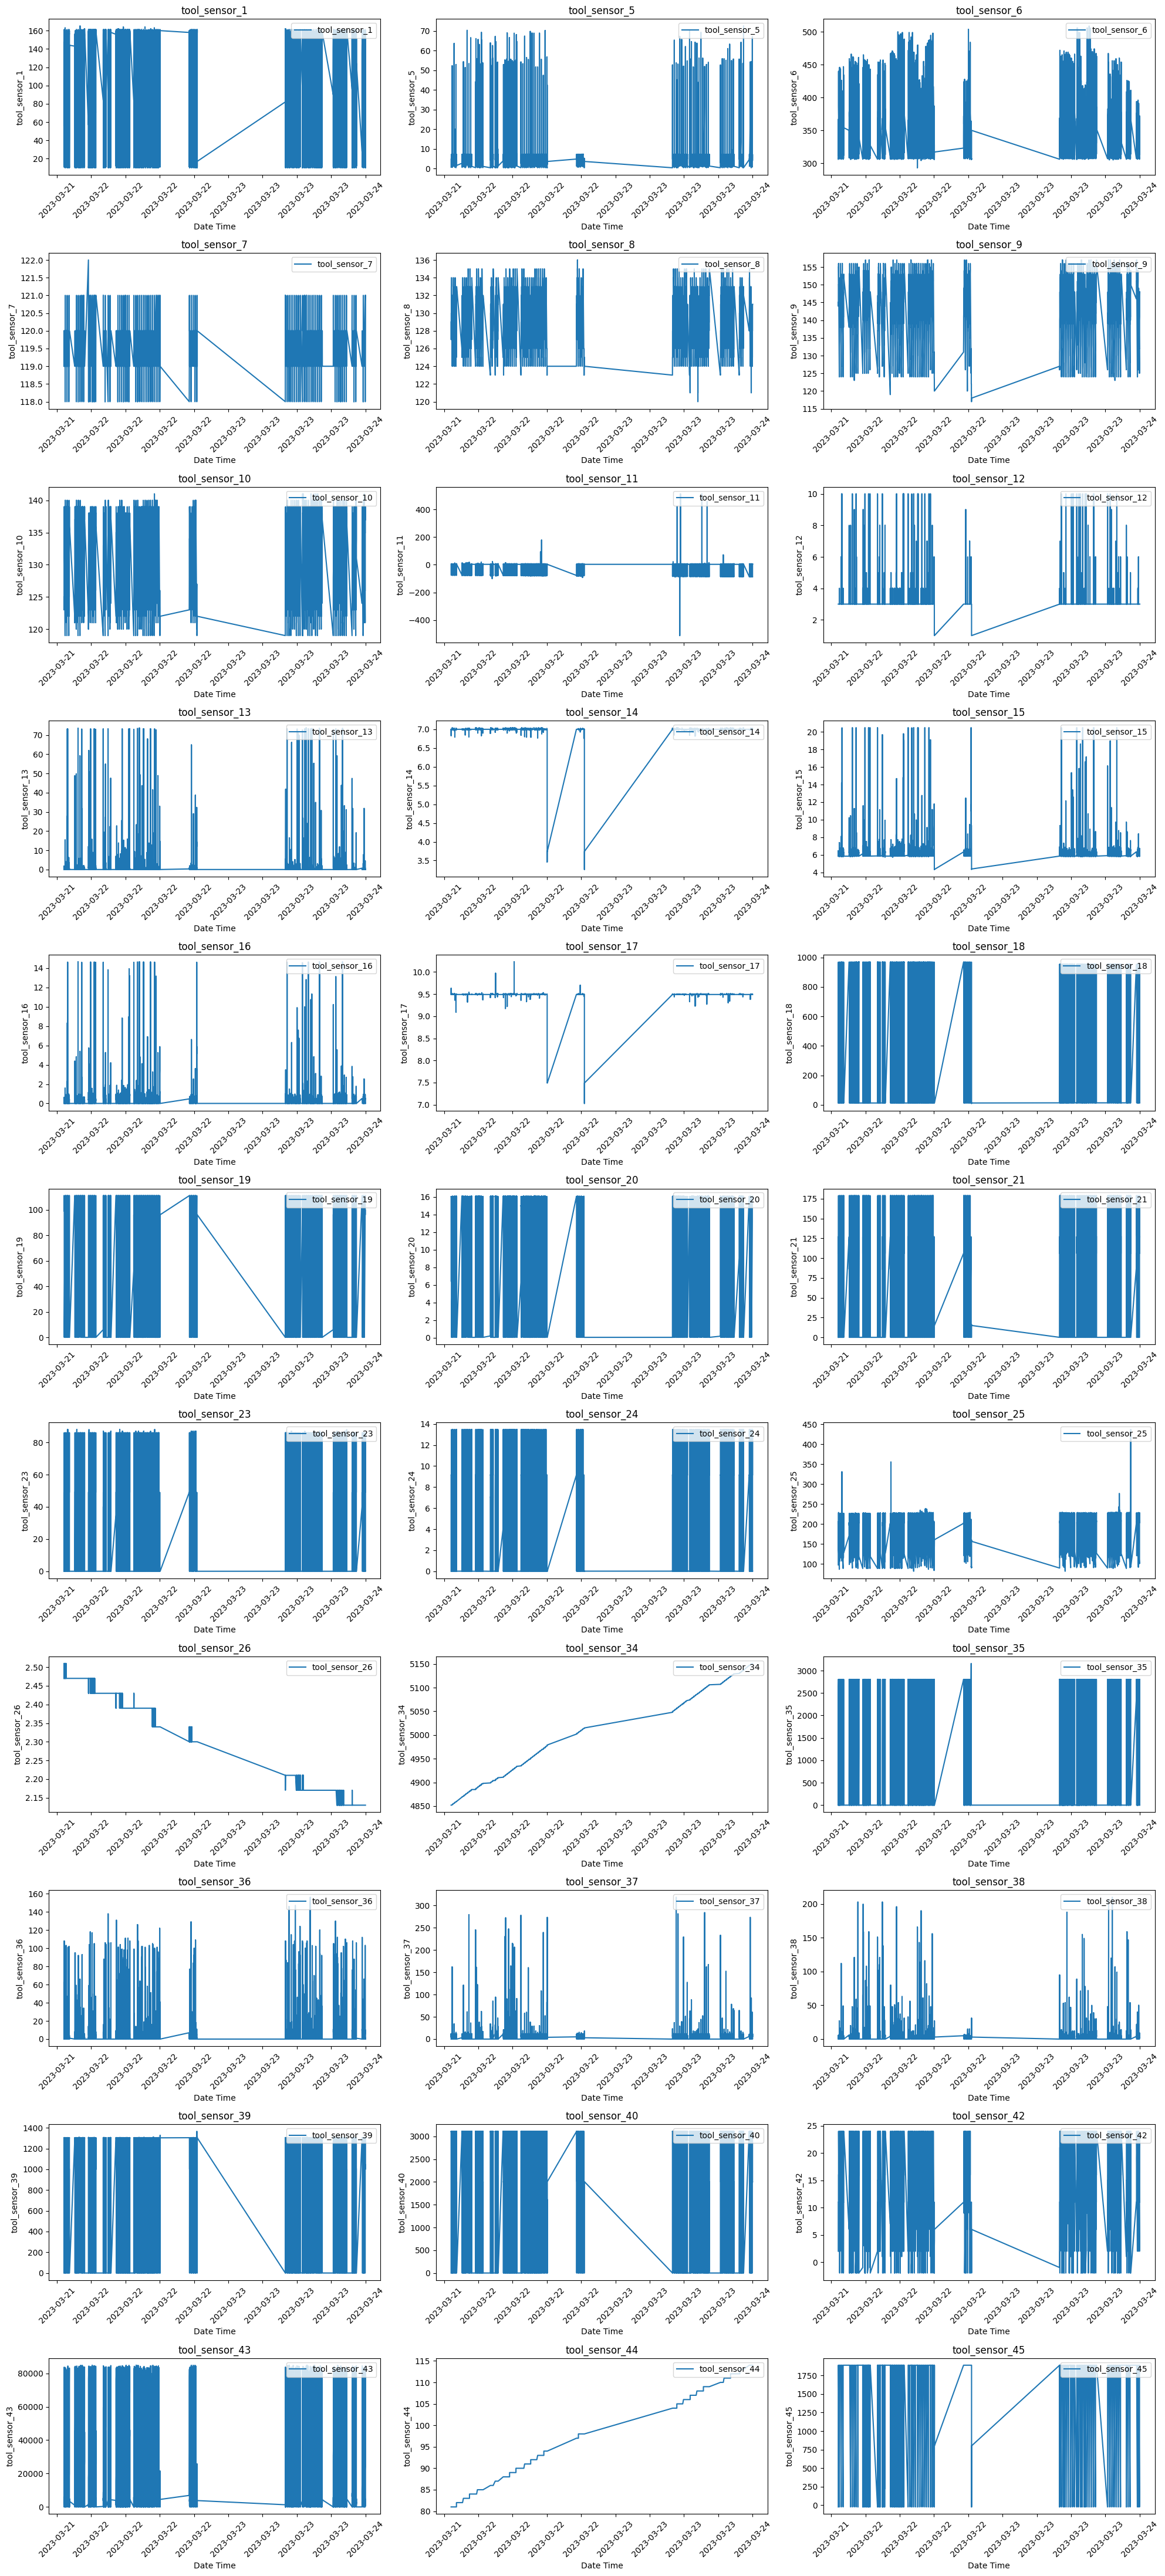

In [189]:
tool_sensor_columns = [col for col in df.columns if 'tool_sensor' in col]

num_sensors = len(tool_sensor_columns)
num_columns = 3
num_rows = (num_sensors // num_columns) + (num_sensors % num_columns > 0)

fig = plt.figure(figsize = (20, 4 * num_rows))

for i, sensor in enumerate(tool_sensor_columns, start = 1):
    ax = fig.add_subplot(num_rows, num_columns, i)
    ax.plot(df['timestamp'], df[sensor], label = sensor)
    ax.set_title(sensor)
    ax.set_xlabel('Date Time')
    ax.set_ylabel(sensor)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis = 'x', rotation = 45)
    ax.legend(loc = 'upper right')

plt.tight_layout()
plt.show()

2.2. Categorical Variable Analysis

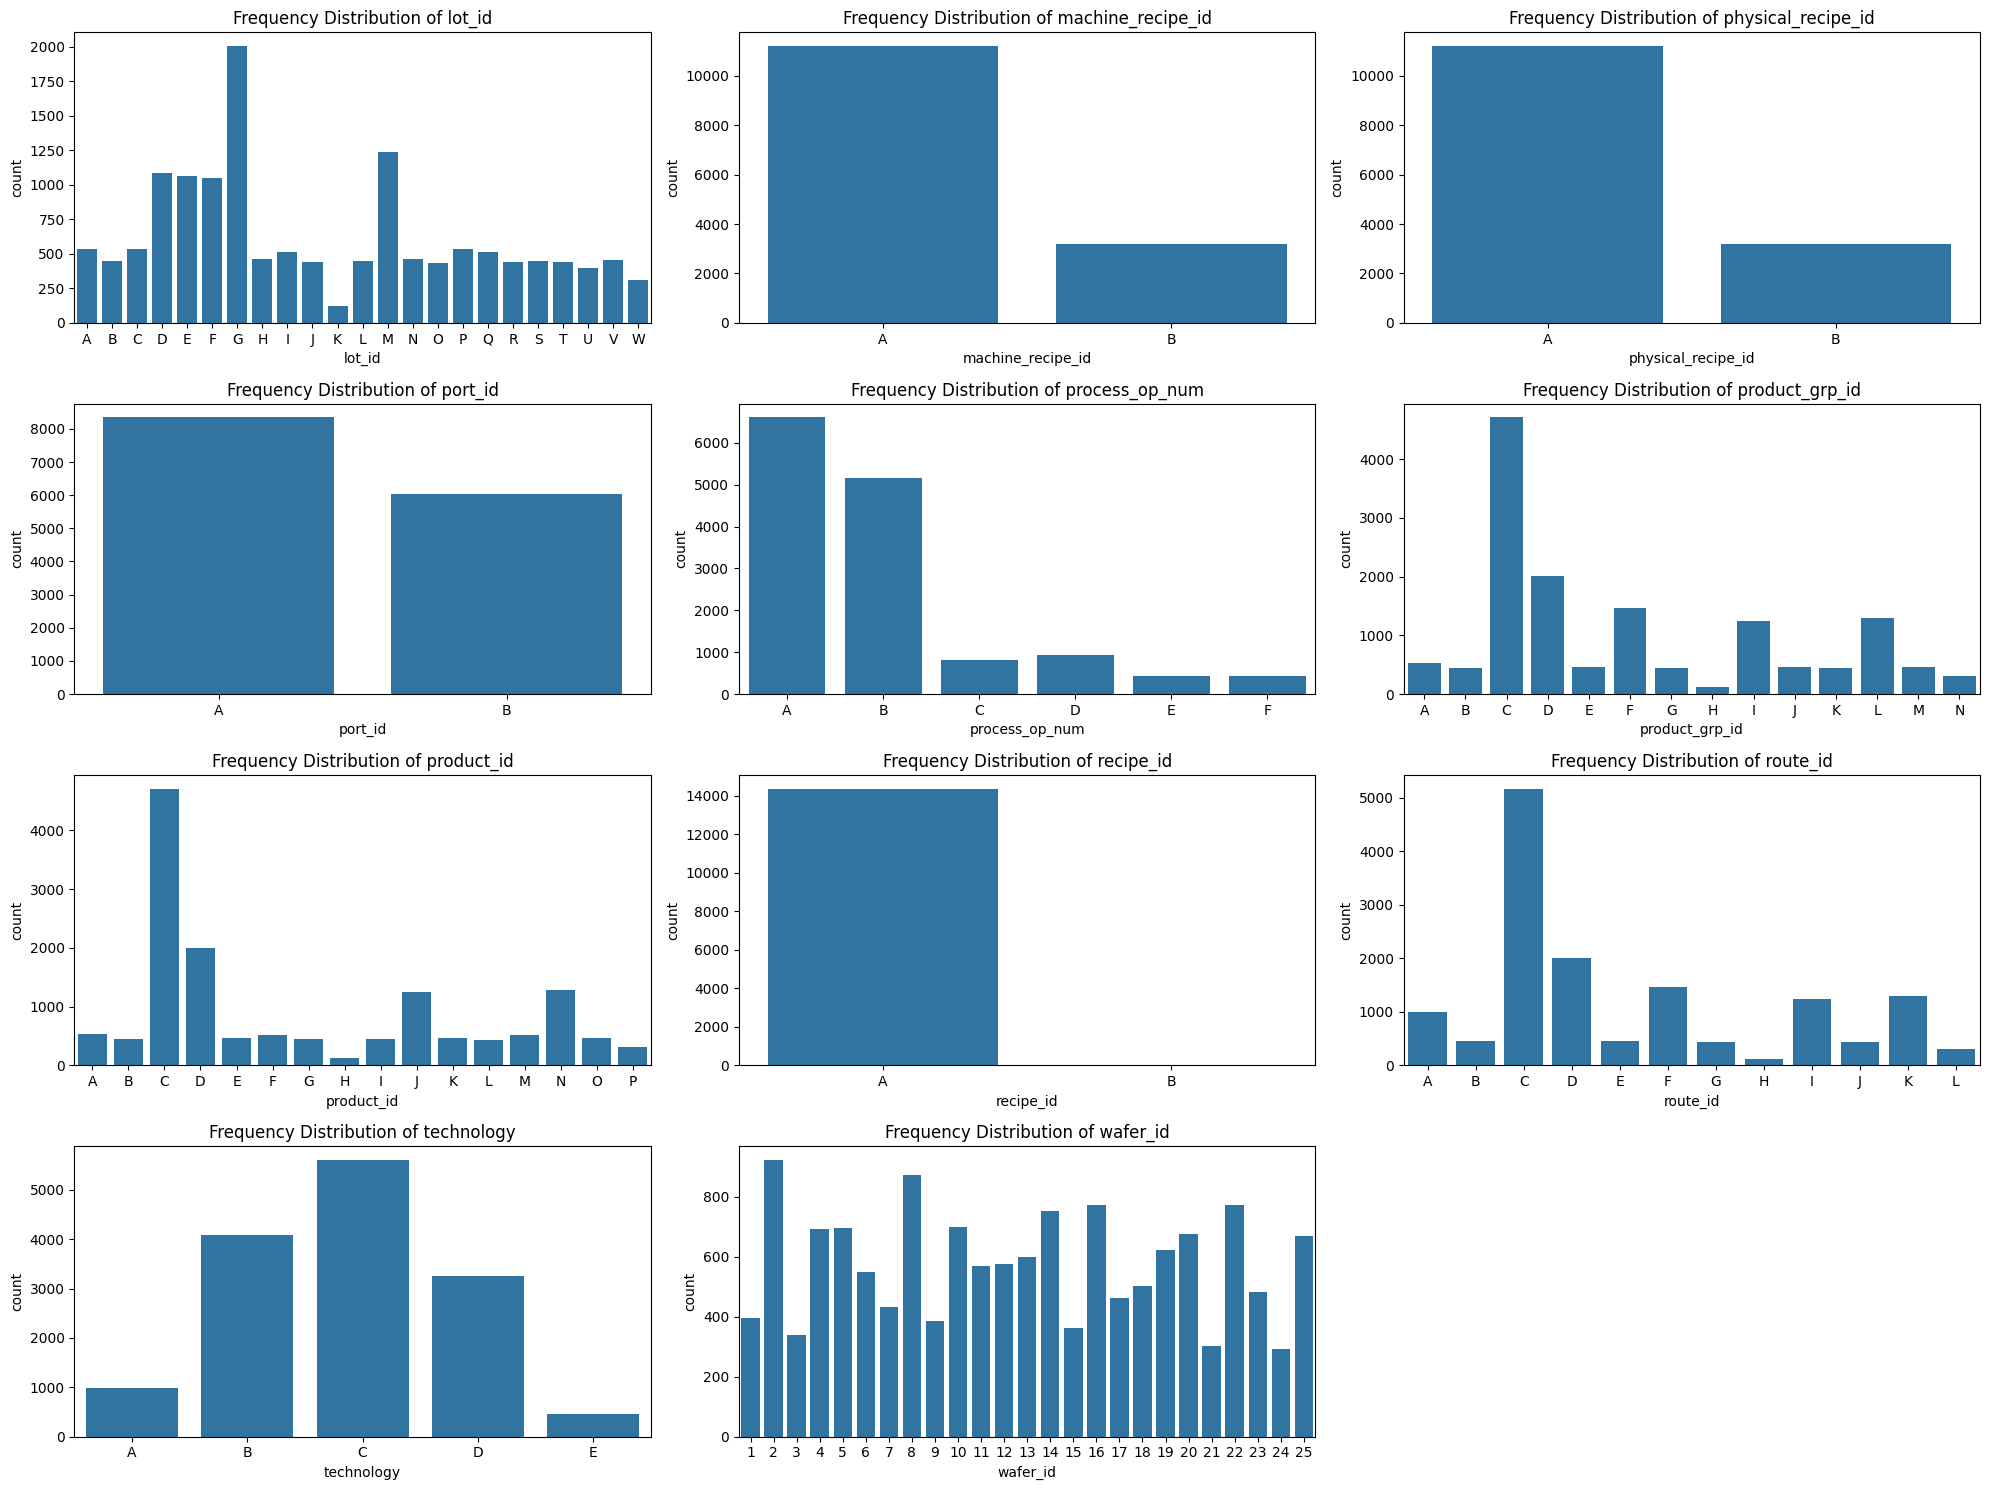

In [143]:
categorical_vars = ['lot_id', 'machine_recipe_id', 'physical_recipe_id', 'port_id', 'process_op_num', 
    'product_grp_id', 'product_id', 'recipe_id', 'route_id', 'technology', 'wafer_id']

plt.figure(figsize = (20, 15))

num_vars = len(categorical_vars)
num_cols = 3
num_rows = (num_vars // num_cols) + (num_vars % num_cols > 0)

for i, var in enumerate(categorical_vars, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.countplot(x = var, data = df)
    plt.title(f'Frequency Distribution of {var}')

plt.tight_layout()
plt.show()

2.3. Relation Between Run, Run Start Time (Second) and Data Quality

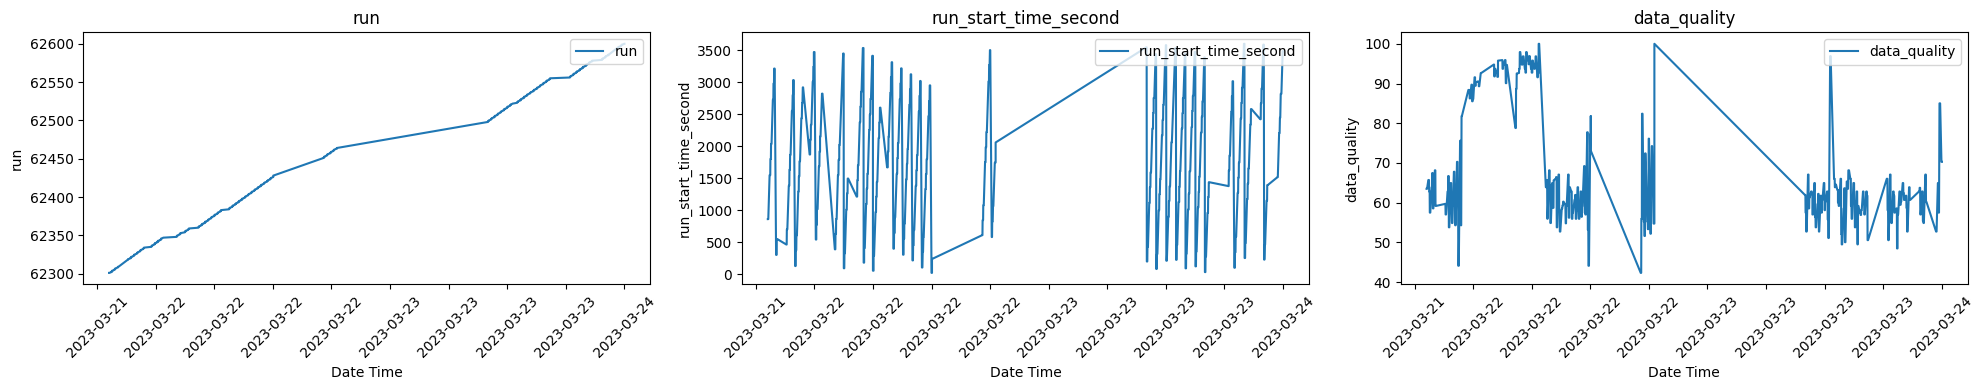

In [190]:
# convert run_start_time to seconds
df['run_start_time_second'] = pd.to_timedelta(df['run_start_time'].astype(str)).dt.total_seconds()

run_data = ['run', 'run_start_time_second', 'data_quality']
num_sensors = len(run_data)
num_columns = 3
num_rows = (num_sensors // num_columns) + (num_sensors % num_columns > 0)

fig = plt.figure(figsize = (20, 4 * num_rows))

for i, run in enumerate(run_data, start = 1):
    ax = fig.add_subplot(num_rows, num_columns, i)
    ax.plot(df['timestamp'], df[run], label = run)
    ax.set_title(run)
    ax.set_xlabel('Date Time')
    ax.set_ylabel(run)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis = 'x', rotation = 45)
    ax.legend(loc = 'upper right')

plt.tight_layout()
plt.show()

2.3. Correlation & Relationship

In [39]:
corr_matrix = df.corr()

plt.figure(figsize = (20, 15))
sns.heatmap(corr_matrix, annot = True, fmt = ".2f", cmap = 'coolwarm')
plt.title('Correlation Matrix')
plt.show()


ValueError: could not convert string to float: 'A'

#### 3. Feature Engineering

In [15]:
# sort the dataframe by timestamp in descending order
df.sort_values(by = 'timestamp', ascending = False)

# initialize encoder and scaler
label_encoder = LabelEncoder()
# standard_scaler = StandardScaler()
# minmax_scaler = MinMaxScaler()

# consider too many features, one hot encoding is not suitable
# apply label encoder
df['lot_id'] = label_encoder.fit_transform(df['lot_id'])
df['machine_recipe_id'] = label_encoder.fit_transform(df['machine_recipe_id'])
df['physical_recipe_id'] = label_encoder.fit_transform(df['physical_recipe_id'])
df['port_id'] = label_encoder.fit_transform(df['port_id'])
df['process_op_num'] = label_encoder.fit_transform(df['process_op_num'])
df['product_grp_id'] = label_encoder.fit_transform(df['product_grp_id'])
df['product_id'] = label_encoder.fit_transform(df['product_id'])
df['recipe_id'] = label_encoder.fit_transform(df['recipe_id'])
df['route_id'] = label_encoder.fit_transform(df['route_id'])
df['technology'] = label_encoder.fit_transform(df['technology'])

# apply scaler
# df['tool_sensor_1'] = minmax_scaler.fit_transform(df['tool_sensor_1'].values.reshape(-1, 1))

for column in df.columns:
    unique_values = df[column].unique()
    if pd.api.types.is_numeric_dtype(df[column]):
        unique_values = np.sort(unique_values)
    print(f"total unique values in '{column}':", len(df[column].unique()))
    print(unique_values)
    print()

total unique values in 'timestamp': 894
<DatetimeArray>
['2023-03-21 19:14:00', '2023-03-21 19:15:00', '2023-03-21 19:16:00',
 '2023-03-21 19:17:00', '2023-03-21 19:25:00', '2023-03-21 19:26:00',
 '2023-03-21 19:27:00', '2023-03-21 19:28:00', '2023-03-21 19:29:00',
 '2023-03-21 19:30:00',
 ...
 '2023-03-23 23:43:00', '2023-03-23 23:46:00', '2023-03-23 23:47:00',
 '2023-03-23 23:48:00', '2023-03-23 23:49:00', '2023-03-23 23:50:00',
 '2023-03-23 23:58:00', '2023-03-23 23:59:00', '2023-03-24 00:00:00',
 '2023-03-24 00:01:00']
Length: 894, dtype: datetime64[ns]

total unique values in 'run': 228
[62301 62302 62303 62304 62305 62306 62307 62308 62309 62318 62319 62320
 62321 62322 62323 62324 62325 62326 62327 62328 62329 62330 62331 62332
 62333 62334 62335 62336 62337 62338 62339 62340 62341 62342 62343 62344
 62345 62346 62347 62348 62349 62350 62351 62352 62353 62354 62355 62356
 62357 62358 62359 62360 62361 62362 62363 62364 62365 62366 62367 62368
 62369 62370 62371 62372 62373 62374

In [16]:
test = df['calc_step_seq'] == df['calc_loop_seq']
test.value_counts()

True    14388
Name: count, dtype: int64

In [17]:
df.shift(axis = 1).head(10)

,timestamp,run,run_start_time,data_quality,lot_id,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,calc_step_seq,calc_loop_seq
1,NaT,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,56.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.00,98.0,2.47,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,500.0,81.0,-25.0,1.0
2,NaT,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,148.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.00,200.0,2.47,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,7.0,300.0,81.0,1890.0,2.0
3,NaT,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,12.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,35.0,4.04,206.0,2.47,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,8.0,300.0,81.0,1890.0,3.0
4,NaT,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,19.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,40.0,7.05,199.0,2.47,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,9.0,6200.0,81.0,1890.0,4.0
5,NaT,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,100.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,49.0,9.15,201.0,2.47,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,11.0,1400.0,81.0,1890.0,5.0
6,NaT,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,140.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,6.0,11.0,5.0,1304.0,3110.0,11.0,9800.0,81.0,1890.0,5.0
7,NaT,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0
8,NaT,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0
9,NaT,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,11.0,4.94,347.0,119.0,127.0,146.0,125.0,-73.0,3.0,0.0,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2802.0,4.0,11.0,5.0,1306.0,3108.0,11.0,14500.0,81.0,1890.0,5.0
10,NaT,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,11.0,4.94,353.0,119.0,127.0,146.0,125.0,-74.0,3.0,0.2,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2803.0,4.0,12.0,5.0,1304.0,3108.0,11.0,16900.0,81.0,1890.0,5.0


#### 4. Feature Selection

In [18]:
df.head(10)

,timestamp,run,run_start_time,data_quality,lot_id,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,calc_step_seq,calc_loop_seq
1,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,56.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.00,98.0,2.47,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,500.0,81.0,-25.0,1.0,1.0
2,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,148.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.00,200.0,2.47,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,7.0,300.0,81.0,1890.0,2.0,2.0
3,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,12.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,35.0,4.04,206.0,2.47,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,8.0,300.0,81.0,1890.0,3.0,3.0
4,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,19.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,40.0,7.05,199.0,2.47,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,9.0,6200.0,81.0,1890.0,4.0,4.0
5,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,100.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,49.0,9.15,201.0,2.47,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,11.0,1400.0,81.0,1890.0,5.0,5.0
6,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,140.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,6.0,11.0,5.0,1304.0,3110.0,11.0,9800.0,81.0,1890.0,5.0,5.0
7,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0,5.0
8,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0,5.0
9,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,11.0,4.94,347.0,119.0,127.0,146.0,125.0,-73.0,3.0,0.0,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2802.0,4.0,11.0,5.0,1306.0,3108.0,11.0,14500.0,81.0,1890.0,5.0,5.0
10,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,11.0,4.94,353.0,119.0,127.0,146.0,125.0,-74.0,3.0,0.2,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2803.0,4.0,12.0,5.0,1304.0,3108.0,11.0,16900.0,81.0,1890.0,5.0,5.0


In [19]:
pca = PCA()
sc = StandardScaler()
x = df.drop(['timestamp', 'run_start_time'], axis = 1).values
x_std = sc.fit_transform(x)
x_pca = pca.fit(x_std)

Text(0, 0.5, 'cumulative explained variance')

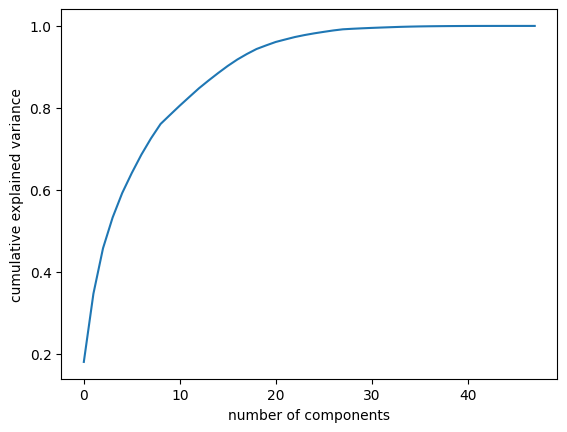

In [20]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [21]:
num_components = len(df.drop(['timestamp', 'run_start_time'], axis = 1).columns)
pca = PCA(num_components)
x_pca = pca.fit_transform(x_std)

In [22]:
pd.DataFrame(pca.components_, columns = df.drop(['timestamp', 'run_start_time'], axis = 1).columns)

,run,data_quality,lot_id,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,calc_step_seq,calc_loop_seq
0,-1.652968e-01,1.343767e-01,-1.594341e-01,0.115935,0.115935,-5.774609e-02,-2.762848e-02,-1.489158e-01,-1.538499e-01,3.045410e-02,-1.193522e-01,4.752413e-02,6.141054e-03,1.268019e-02,2.521401e-02,-8.919760e-02,6.910250e-02,8.453253e-02,2.077670e-02,2.619891e-02,2.670307e-01,-2.703355e-02,-3.189096e-02,-3.016670e-02,-7.595839e-02,-7.814689e-02,-3.009780e-02,-2.586316e-01,-1.988360e-01,-1.982446e-01,-1.860996e-01,-2.372120e-01,-2.485054e-01,-2.061256e-01,1.625670e-01,-1.653050e-01,-2.500890e-01,-5.472776e-02,-3.416564e-02,1.635697e-02,-2.589203e-01,-2.730467e-01,7.454153e-02,-1.451297e-01,-1.647616e-01,-1.096030e-01,0.169405,0.169405
1,2.872052e-01,-1.933146e-01,2.823207e-01,-0.175697,-0.175697,7.226477e-02,4.040180e-02,2.699579e-01,2.751126e-01,3.291336e-02,2.209710e-01,-7.567798e-02,-1.316519e-02,-3.430559e-02,1.720019e-02,-7.478930e-02,1.574156e-02,-7.098722e-04,-3.951560e-02,-2.507546e-02,1.162630e-01,-9.765531e-03,-1.079929e-02,-3.331345e-02,-2.844291e-02,-2.623793e-02,-3.375776e-02,-1.487158e-01,-1.436331e-01,-1.447024e-01,-1.481462e-01,-1.486034e-01,-1.527789e-01,-1.548464e-01,-2.825877e-01,2.871987e-01,-1.484646e-01,8.476411e-03,-9.042725e-03,1.835358e-02,-1.736543e-01,-1.773473e-01,2.936005e-03,-9.354008e-02,2.858814e-01,-8.314622e-02,-0.028051,-0.028051
2,-6.334140e-02,1.669024e-02,-6.256264e-02,-0.009188,-0.009188,-2.115493e-02,-2.124165e-03,-4.924423e-02,-5.230584e-02,6.744961e-02,-3.610909e-02,1.365476e-02,-1.586673e-02,2.960926e-02,9.850669e-02,-1.379650e-01,-2.173818e-01,-3.536972e-01,-3.287114e-01,-3.854666e-01,-8.670437e-02,1.222401e-01,1.433864e-01,-7.297851e-02,1.511843e-01,1.571164e-01,-7.100831e-02,1.035753e-01,-2.049574e-02,-2.136891e-02,-2.324557e-01,-6.659803e-02,-4.366540e-02,-2.126988e-01,6.006446e-02,-6.335097e-02,1.754457e-03,5.152592e-03,1.178205e-01,8.119761e-02,-2.895638e-02,-1.977783e-02,-3.560688e-01,-1.067827e-03,-6.483714e-02,-1.943047e-01,-0.228979,-0.228979
3,1.383797e-02,1.931500e-03,1.599072e-02,0.014644,0.014644,3.555708e-03,-6.409587e-03,1.321097e-02,1.346359e-02,-1.847225e-01,1.118419e-02,1.667104e-02,8.809311e-03,-1.809494e-02,-9.819981e-02,-3.375494e-02,4.086317e-02,6.634359e-02,4.723437e-02,5.736562e-02,1.661463e-02,4.696711e-01,4.471995e-01,1.673633e-01,4.417745e-01,4.286347e-01,1.724140e-01,-1.424219e-02,-5.862287e-02,-4.089373e-02,3.847440e-02,-2.314471e-02,-4.179518e-02,1.407584e-02,-1.275142e-02,1.383711e-02,-8.070529e-02,3.639816e-03,-7.604811e-02,-5.834112e-02,-2.903125e-02,-1.372567e-02,1.040317e-01,-6.292375e-02,1.384143e-02,1.182368e-01,0.119573,0.119573
4,-3.270970e-03,2.425991e-02,4.099800e-03,-0.001026,-0.001026,-2.997237e-02,-2.058160e-02,1.320410e-02,9.277964e-03,5.285757e-01,2.276750e-02,-5.756576e-03,-1.844626e-02,4.385297e-03,-1.155131e-01,4.942238e-02,6.051271e-02,5.543406e-02,3.157418e-02,7.583070e-02,-3.932564e-03,6.787295e-02,1.529114e-01,-5.396132e-01,1.204413e-01,1.584062e-01,-5.302271e-01,2.444257e-03,-3.495472e-02,-9.704916e-02,5.941585e-02,5.154372e-02,4.009268e-02,3.844635e-02,7.047098e-03,-3.260920e-03,1.314264e-02,-8.952275e-03,3.331951e-02,-5.411291e-02,3.572905e-02,1.644844e-02,6.923653e-02,1.094430e-02,-5.200589e-03,1.090450e-01,0.053167,0.053167
5,3.240868e-02,8.227111e-02,2.821081e-02,0.094058,0.094058,3.136363e-02,2.675451e-02,1.996850e-02,1.809061e-02,6.109590e-02,2.013724e-02,3.892814e-02,-1.1

In [49]:
n_pcs = pca.n_components_ # get number of component

# get the index of the most important feature on each component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
intial_feature_names = df.drop(['timestamp', 'run_start_time'], axis = 1).columns

# get the most important feature names
most_important_feature_names = [intial_feature_names[most_important[i]] for i in range(n_pcs)]
most_important_feature_names

['tool_sensor_40',
 'run',
 'tool_sensor_10',
 'tool_sensor_12',
 'tool_sensor_14',
 'tool_sensor_19',
 'machine_recipe_id',
 'tool_sensor_5',
 'process_op_num',
 'tool_sensor_1',
 'tool_sensor_38',
 'tool_sensor_36',
 'wafer_id',
 'tool_sensor_1',
 'port_id',
 'tool_sensor_1',
 'tool_sensor_38',
 'tool_sensor_7',
 'route_id',
 'technology',
 'tool_sensor_6',
 'tool_sensor_11',
 'tool_sensor_42',
 'data_quality',
 'tool_sensor_45',
 'product_grp_id',
 'data_quality',
 'tool_sensor_42',
 'tool_sensor_25',
 'tool_sensor_10',
 'tool_sensor_17',
 'tool_sensor_8',
 'tool_sensor_18',
 'product_id',
 'tool_sensor_40',
 'tool_sensor_35',
 'tool_sensor_26',
 'tool_sensor_19',
 'tool_sensor_39',
 'tool_sensor_13',
 'lot_id',
 'tool_sensor_14',
 'tool_sensor_15',
 'tool_sensor_24',
 'tool_sensor_44',
 'run',
 'physical_recipe_id',
 'calc_step_seq']

In [50]:
# get the absolute values of pca components
abs_components = np.abs(pca.components_)

# sum the importance of each feature across all components
feature_importances = np.sum(abs_components, axis = 0)

# get initial feature names, excluding 'timestamp' and 'run_start_time'
initial_feature_names = df.drop(['timestamp', 'run_start_time'], axis = 1).columns

# create a dictionary mapping feature names to their overall importance
importance_dict = dict(zip(initial_feature_names, feature_importances))

# sort the dictionary by importance
sorted_importance = sorted(importance_dict.items(), key = lambda x: x[1], reverse = True)

# extracting the sorted feature names and their importances
sorted_feature_names, sorted_importances = zip(*sorted_importance)

# now, sorted_feature_names contains all features sorted by their overall importance
print(sorted_feature_names)
print(sorted_importances)

('tool_sensor_45', 'tool_sensor_35', 'tool_sensor_43', 'tool_sensor_5', 'tool_sensor_9', 'tool_sensor_21', 'tool_sensor_8', 'tool_sensor_23', 'product_grp_id', 'product_id', 'tool_sensor_38', 'tool_sensor_6', 'tool_sensor_42', 'tool_sensor_10', 'tool_sensor_11', 'tool_sensor_20', 'tool_sensor_18', 'tool_sensor_7', 'tool_sensor_37', 'tool_sensor_12', 'tool_sensor_19', 'tool_sensor_24', 'tool_sensor_13', 'tool_sensor_25', 'calc_loop_seq', 'calc_step_seq', 'route_id', 'tool_sensor_16', 'tool_sensor_39', 'data_quality', 'tool_sensor_40', 'lot_id', 'tool_sensor_15', 'physical_recipe_id', 'machine_recipe_id', 'technology', 'tool_sensor_26', 'port_id', 'tool_sensor_36', 'run', 'tool_sensor_34', 'process_op_num', 'tool_sensor_1', 'recipe_id', 'tool_sensor_44', 'tool_sensor_17', 'wafer_id', 'tool_sensor_14')
(4.892461820466854, 4.681524200704615, 4.6466671414808065, 4.6419082283750495, 4.636192094409683, 4.54015793735503, 4.417531362381282, 4.331073641109447, 4.323142906920928, 4.14722216214440

#### 5. Hyperparameter Tuning

#### 6. Model Training

In [51]:
x = df.drop(['timestamp', 'run_start_time'], axis = 1)

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [52]:
# isolation forest
model = IsolationForest()
model.fit(x_scaled)

df['anomaly'] = model.predict(x_scaled)
# convert predictions to a binary flag (1 for anomaly, 0 for normal)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})

In [53]:
# one class svm
model = OneClassSVM()
model.fit(x_scaled)

df['anomaly2'] = model.predict(x_scaled)
# convert predictions to a binary flag (1 for anomaly, 0 for normal)
df['anomaly2'] = df['anomaly2'].map({1: 0, -1: 1})

In [54]:
df.head(10)

,timestamp,run,run_start_time,data_quality,lot_id,machine_recipe_id,physical_recipe_id,port_id,process_op_num,product_grp_id,product_id,recipe_id,route_id,technology,wafer_id,tool_sensor_1,tool_sensor_5,tool_sensor_6,tool_sensor_7,tool_sensor_8,tool_sensor_9,tool_sensor_10,tool_sensor_11,tool_sensor_12,tool_sensor_13,tool_sensor_14,tool_sensor_15,tool_sensor_16,tool_sensor_17,tool_sensor_18,tool_sensor_19,tool_sensor_20,tool_sensor_21,tool_sensor_23,tool_sensor_24,tool_sensor_25,tool_sensor_26,tool_sensor_34,tool_sensor_35,tool_sensor_36,tool_sensor_37,tool_sensor_38,tool_sensor_39,tool_sensor_40,tool_sensor_42,tool_sensor_43,tool_sensor_44,tool_sensor_45,calc_step_seq,calc_loop_seq,anomaly,anomaly2
1,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,56.0,0.71,306.0,119.0,129.0,145.0,125.0,3.0,3.0,0.0,7.00,5.85,0.00,9.49,13.0,99.0,6.46,0.0,0.0,0.00,98.0,2.47,4852.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,500.0,81.0,-25.0,1.0,1.0,1,1
2,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,148.0,3.76,308.0,119.0,128.0,144.0,123.0,-72.0,3.0,0.0,7.00,5.84,0.00,9.49,968.0,111.0,16.03,127.0,0.0,0.00,200.0,2.47,4852.0,1.0,0.0,12.0,5.0,1304.0,3110.0,7.0,300.0,81.0,1890.0,2.0,2.0,0,1
3,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,12.0,4.17,307.0,120.0,128.0,144.0,123.0,-72.0,3.0,0.2,6.83,5.85,0.01,9.63,968.0,111.0,16.06,127.0,35.0,4.04,206.0,2.47,4852.0,1.0,0.0,8.0,4.0,1305.0,3107.0,8.0,300.0,81.0,1890.0,3.0,3.0,1,1
4,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,19.0,4.44,307.0,119.0,127.0,144.0,123.0,-72.0,3.0,1.8,7.00,6.45,0.61,9.49,968.0,111.0,16.06,86.0,40.0,7.05,199.0,2.47,4852.0,1251.0,0.0,6.0,3.0,1302.0,3104.0,9.0,6200.0,81.0,1890.0,4.0,4.0,0,1
5,2023-03-21 19:14:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,100.0,4.66,307.0,119.0,127.0,145.0,123.0,-72.0,3.0,0.7,7.00,6.33,0.49,9.49,968.0,111.0,16.06,106.0,49.0,9.15,201.0,2.47,4852.0,2651.0,63.0,4.0,2.0,1302.0,3103.0,11.0,1400.0,81.0,1890.0,5.0,5.0,1,1
6,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,140.0,4.92,331.0,119.0,127.0,145.0,124.0,-73.0,3.0,0.0,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,6.0,11.0,5.0,1304.0,3110.0,11.0,9800.0,81.0,1890.0,5.0,5.0,0,1
7,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0,5.0,0,1
8,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,145.0,4.93,337.0,120.0,127.0,145.0,124.0,-73.0,3.0,0.1,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2801.0,5.0,11.0,5.0,1304.0,3110.0,11.0,11300.0,81.0,1890.0,5.0,5.0,0,1
9,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,11.0,4.94,347.0,119.0,127.0,146.0,125.0,-73.0,3.0,0.0,7.00,6.27,0.43,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2802.0,4.0,11.0,5.0,1306.0,3108.0,11.0,14500.0,81.0,1890.0,5.0,5.0,0,1
10,2023-03-21 19:15:00,62301,00:14:19,63.49,0,0,0,0,0,0,0,0,0,0,1,11.0,4.94,353.0,119.0,127.0,146.0,125.0,-74.0,3.0,0.2,7.00,6.28,0.44,9.49,968.0,111.0,16.06,106.0,49.0,9.14,204.0,2.51,4852.0,2803.0,4.0,12.0,5.0,1304.0,3108.0,11.0,16900.0,81.0,1890.0,5.0,5.0,0,1


#### 7. Model Prediction

#### 8. Anomaly Detection

#### 9. Model Explainability (Optional)